# Neural Networks Continued

This notebook will attempt to train some Neural Networks on the Training data and save it for later use. It is an extension of 011 as I kept running into problems there

## Author: Alexander Goudemond, Student Number: 219030365

In this notebook, we are going to begin looking at training some neural networks.

I have tried to go through several U-net tutorials - all of which failed. I suspect there is a combination of problems affecting me:

- The tutorial data-sets are not clean or not accessible (hosted on private servers or websites, like Kaggle, Medium, PyImageSearch)

- The implementation is complicated and built on old dependencies

- there is too much data being brought in for training at one time, for offline use

- the offline training I have been trying to do is not possible, as my Graphics Card does not have enough VRAM

To try and overcome these challenges - I am going to load a single folder from our data-set into some training variables, and attempt to train a model on just those. I am unable to do an example tutorial - so I am hoping for the best with my implementation

# Mount Drive

We need to access some images loaded into Google Drive, so here we mount it

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Please ensure the following folders exist

drive > MyDrive > COMP700_Images > COMP700_Training_GT

drive > MyDrive > COMP700_Images > COMP700_Training_ST

drive > MyDrive > COMP700_Neural_Network_Code

The latter location is where the Jupyter Notebooks will be loaded, and the former directories will contain the images used. These images are generated offline by the other notebooks and then uploaded to Google Drive

# Imports

In [ ]:
from os import getcwd, walk, mkdir, stat, remove
from os import sep # used later on, in a function, to print directory contents
from os.path import exists, basename, join

from shutil import copyfile

from PIL.Image import fromarray
import cv2

import matplotlib.pyplot as plt
import numpy as np

# Load images into variables

We will be going to our training data and fetching 1 folder for our x and y training variables. Once that is successful, we will explore training on each of the datasets together

In [ ]:
getcwd()

'/content'

In [ ]:
google_drive_path = "/drive/MyDrive"
training_data_folder = "COMP700_Training_GT"
training_data_directory = getcwd() + google_drive_path + "/COMP700_Images/" + training_data_folder
desired_directory = ""

maxLength = -1
length = 0

# look for largest length
for root, dirs, files in walk(training_data_directory):
    if (len(files) > 0):
        length = len(files)

        if (maxLength < length):
            desired_directory = root
            maxLength = length

print(desired_directory)


/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-N2DH-SIM+/Fluo-N2DH-SIM+/02/X


Let's remove the X and prepare the data for training:

In [ ]:
desired_directory = desired_directory[ : -2]

desired_directory

'/content/drive/MyDrive/COMP700_Images/COMP700_Training_GT/Fluo-N2DH-SIM+/Fluo-N2DH-SIM+/02'

In [ ]:
# get paths

x_training_paths = []
y_training_paths = []

for root, dirs, files in walk(desired_directory):
    if ("X" in root):
        x_training_paths = files
    else:
        y_training_paths = files

print("Length of X Training:", len(x_training_paths))
print("Length of Y Training:", len(y_training_paths))

# update the paths:

for i in range(len(x_training_paths)):
    x_training_paths[i] = desired_directory + "/X/" + x_training_paths[i]
    y_training_paths[i] = desired_directory + "/Y/" + y_training_paths[i]

Length of X Training: 150
Length of Y Training: 150


#### One of the things that may be causing problems is the fact the input and output images have the same dimension. I am going to attempt to change the dimension of the output image here to a (128, 128, 1) and see if that helps

In [ ]:
# We can now try to write those images into an array of images:
x_training_images = []
y_training_images = []

for i in range(len(x_training_paths)):
    x_training_images.append( cv2.imread(x_training_paths[i]) )
    y_training_images.append( cv2.imread(y_training_paths[i], cv2.IMREAD_GRAYSCALE) )

# get shapes to check dimension
print(np.array(x_training_images).shape)
print(np.array(y_training_images).shape)

(150, 773, 739, 3)
(150, 773, 739)


In [ ]:
x_training_images_resized = []
y_training_images_resized = []
dim = (128, 128)

for i in range(len(y_training_images)):
    img = x_training_images[i]
    x_training_images_resized.append( cv2.resize(img, dim) ) 

    img = y_training_images[i]
    y_training_images_resized.append( cv2.resize(img, dim) ) 

# get shapes to check dimension
print(np.array(x_training_images_resized).shape)
print(np.array(y_training_images_resized).shape)

(150, 128, 128, 3)
(150, 128, 128)


Shape: (128, 128, 3)


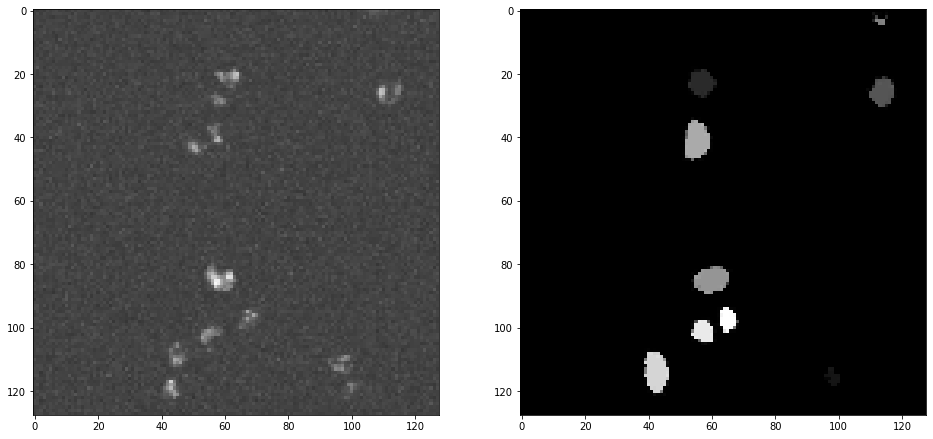

In [ ]:
# Let's now try show these images side by side to verify results:

from random import randint

index = randint(0, len(x_training_images_resized) - 1)
print("Shape:", x_training_images_resized[index].shape)

fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.imshow(x_training_images_resized[index])

plt.subplot(1, 2, 2)
plt.imshow(y_training_images_resized[index], cmap="gray")

plt.show()

In [ ]:
TRAIN_LENGTH = len(x_training_images_resized)

partition_index = (int) (0.8 * TRAIN_LENGTH)

x_train = x_training_images_resized[ : partition_index ]
y_train = y_training_images_resized[ : partition_index ]

x_valid = x_training_images_resized[ : partition_index ]
y_valid = y_training_images_resized[ : partition_index ]

# convert to numpy arrays for tensorflow
x_train = np.array(x_train)
y_train = np.array(y_train)

x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

data_valid = (x_valid, y_valid)

In [ ]:
print(x_train.shape)

(120, 128, 128, 3)


# Unet Model

## Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Input, Lambda

In [ ]:
# original author: "Sreenivas Bhattiprolu"
# Github directory: "Python for Microscopists"
# URL: https://github.com/bnsreenu/python_for_microscopists
def get_unet(img_width, img_height, input_channels, output_channels):
    #Build the model
    inputs = Input((img_width, img_height, input_channels))
    s = Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(output_channels, (1, 1), activation='sigmoid')(c9) # output_channels will be updated to 1 here...

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model
###

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_INPUT = 3
IMG_OUTPUT = 1

unet_model_adam = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

In [ ]:
unet_model_adam.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
ACCURACY_THRESHOLD = 0.75

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') > ACCURACY_THRESHOLD):
			print("\nReached %2.2f%% loss, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Instantiate a callback object
CALLBACKS = myCallback()

In [ ]:
unet_model_adam.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=600

unet_model_adam_history = unet_model_adam.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/600
5/7 [====================>.........] - ETA: 0s - loss: -141.3174 - accuracy: 0.0055

7/7 [==============================] - 0s 57ms/step - loss: -132.4219 - accuracy: 0.0052 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 2/600
7/7 [==============================] - 0s 41ms/step - loss: -132.4088 - accuracy: 0.0052 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 3/600
7/7 [==============================] - 0s 42ms/step - loss: -132.4337 - accuracy: 0.0052 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 4/600
7/7 [==============================] - 0s 41ms/step - loss: -132.4149 - accuracy: 0.0052 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 5/600
7/7 [==============================] - 0s 41ms/step - loss: -132.4040 - accuracy: 0.0052 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 6/600
7/7 [==============================] - 0s 41ms/step - loss: -132.4102 - accuracy: 0.0052 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 7/600
7/7 [==============================] - 0s 41ms/step - loss: -132.3996 - accuracy: 0.0052 - val_loss: -132.6740 - val_accurac

That is better than the previous notebook!

Now, let us try different optimizers to try improve accuracy and go from there:

### Adam:

In [ ]:
## Implemented above

### SGD:

In [ ]:
unet_model_sgd = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_sgd.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=600

unet_model_sgd_history = unet_model_sgd.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/600
6/7 [========================>.....] - ETA: 0s - loss: -135.1717 - accuracy: 0.0050

7/7 [==============================] - 0s 63ms/step - loss: -132.4666 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 2/600
7/7 [==============================] - 0s 42ms/step - loss: -132.4665 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 3/600
7/7 [==============================] - 0s 42ms/step - loss: -132.4665 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 4/600
7/7 [==============================] - 0s 41ms/step - loss: -132.4665 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 5/600
7/7 [==============================] - 0s 42ms/step - loss: -132.4666 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 6/600
7/7 [==============================] - 0s 42ms/step - loss: -132.4666 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 7/600
7/7 [==============================] - 0s 42ms/step - loss: -132.4665 - accuracy: 0.0050 - val_loss: -132.6740 - val_accurac

### RMSprop:

In [ ]:
unet_model_rmsprop = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_rmsprop.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=600

unet_model_rmsprop_history = unet_model_rmsprop.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/600
7/7 [==============================] - 3s 106ms/step - loss: -93.6968 - accuracy: 0.0850 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 2/600
7/7 [==============================] - 0s 44ms/step - loss: -132.4667 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 3/600
7/7 [==============================] - 0s 44ms/step - loss: -132.4667 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 4/600
7/7 [==============================] - 0s 43ms/step - loss: -132.4667 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 5/600
7/7 [==============================] - 0s 44ms/step - loss: -132.4667 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 6/600
7/7 [==============================] - 0s 44ms/step - loss: -132.4605 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 7/600
7/7 [==============================] - 0s 43ms/step - loss: -132.4232 - accuracy: 0.0051 - val_loss: -132.6740 -

That looks promising!

### Adadelta:

In [ ]:
unet_model_adadelta = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_adadelta.compile(optimizer='Adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=600

unet_model_adadelta_history = unet_model_adadelta.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/600
6/7 [========================>.....] - ETA: 0s - loss: 1.1842 - accuracy: 0.6818

7/7 [==============================] - 2s 106ms/step - loss: 1.1814 - accuracy: 0.6818 - val_loss: 1.3743 - val_accuracy: 0.8949
Epoch 2/600
7/7 [==============================] - 0s 44ms/step - loss: 1.1749 - accuracy: 0.6774 - val_loss: 1.3614 - val_accuracy: 0.8944
Epoch 3/600
7/7 [==============================] - 0s 44ms/step - loss: 1.1586 - accuracy: 0.6722 - val_loss: 1.3483 - val_accuracy: 0.8940
Epoch 4/600
7/7 [==============================] - 0s 43ms/step - loss: 1.1463 - accuracy: 0.6679 - val_loss: 1.3350 - val_accuracy: 0.8934
Epoch 5/600
7/7 [==============================] - 0s 44ms/step - loss: 1.1266 - accuracy: 0.6628 - val_loss: 1.3216 - val_accuracy: 0.8928
Epoch 6/600
7/7 [==============================] - 0s 43ms/step - loss: 1.1178 - accuracy: 0.6578 - val_loss: 1.3081 - val_accuracy: 0.8921
Epoch 7/600
7/7 [==============================] - 0s 43ms/step - loss: 1.0973 - accuracy: 0.6534 - val_loss: 1.2943 - val_accuracy: 0.8914
Epoch 8/600
7/7 [==============

### Adagrad:

In [ ]:
unet_model_adagrad = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_adagrad.compile(optimizer='Adagrad', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=600

unet_model_adagrad_history = unet_model_adagrad.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/600
5/7 [====================>.........] - ETA: 0s - loss: 0.6395 - accuracy: 0.3359

7/7 [==============================] - 2s 104ms/step - loss: 0.5375 - accuracy: 0.2715 - val_loss: 0.0404 - val_accuracy: 0.0066
Epoch 2/600
7/7 [==============================] - 0s 43ms/step - loss: -0.2400 - accuracy: 0.0223 - val_loss: -0.7341 - val_accuracy: 0.0048
Epoch 3/600
7/7 [==============================] - 0s 44ms/step - loss: -1.3275 - accuracy: 0.0064 - val_loss: -2.1888 - val_accuracy: 0.0048
Epoch 4/600
7/7 [==============================] - 0s 43ms/step - loss: -3.9299 - accuracy: 0.0052 - val_loss: -6.6869 - val_accuracy: 0.0048
Epoch 5/600
7/7 [==============================] - 0s 44ms/step - loss: -44.1663 - accuracy: 0.0051 - val_loss: -129.5238 - val_accuracy: 0.0048
Epoch 6/600
7/7 [==============================] - 0s 43ms/step - loss: -131.9989 - accuracy: 0.0051 - val_loss: -131.0205 - val_accuracy: 0.0048
Epoch 7/600
7/7 [==============================] - 0s 43ms/step - loss: -132.3286 - accuracy: 0.0051 - val_loss: -131.6356 - val_accuracy: 0.0048
Epoch 8/

### Adamax:

In [ ]:
unet_model_adamax = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_adamax.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=600

unet_model_adamax_history = unet_model_adamax.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/600
6/7 [========================>.....] - ETA: 0s - loss: -59.6463 - accuracy: 0.1050

7/7 [==============================] - 2s 106ms/step - loss: -68.0316 - accuracy: 0.0943 - val_loss: -132.7100 - val_accuracy: 0.0048
Epoch 2/600
7/7 [==============================] - 0s 43ms/step - loss: -132.3463 - accuracy: 0.0061 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 3/600
7/7 [==============================] - 0s 42ms/step - loss: -132.4238 - accuracy: 0.0054 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 4/600
7/7 [==============================] - 0s 43ms/step - loss: -132.4471 - accuracy: 0.0052 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 5/600
7/7 [==============================] - 0s 43ms/step - loss: -132.4522 - accuracy: 0.0052 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 6/600
7/7 [==============================] - 0s 43ms/step - loss: -132.4563 - accuracy: 0.0052 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 7/600
7/7 [==============================] - 0s 43ms/step - loss: -132.4560 - accuracy: 0.0052 - val_loss: -132.6740 - val_accurac

### Nadam:

In [ ]:
unet_model_nadam = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_nadam.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=600

unet_model_nadam_history = unet_model_nadam.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/600
7/7 [==============================] - 5s 138ms/step - loss: -92.6466 - accuracy: 0.0333 - val_loss: -132.6880 - val_accuracy: 0.0049
Epoch 2/600
7/7 [==============================] - 0s 50ms/step - loss: -132.4814 - accuracy: 0.0059 - val_loss: -132.7047 - val_accuracy: 0.0067
Epoch 3/600
7/7 [==============================] - 1s 78ms/step - loss: -132.5053 - accuracy: 0.0077 - val_loss: -132.7439 - val_accuracy: 0.0092
Epoch 4/600
7/7 [==============================] - 0s 47ms/step - loss: -132.5531 - accuracy: 0.0106 - val_loss: -132.7892 - val_accuracy: 0.0123
Epoch 5/600
7/7 [==============================] - 0s 45ms/step - loss: -132.5680 - accuracy: 0.0123 - val_loss: -132.7922 - val_accuracy: 0.0125
Epoch 6/600
7/7 [==============================] - 0s 47ms/step - loss: -132.4915 - accuracy: 0.0133 - val_loss: -132.7874 - val_accuracy: 0.0122
Epoch 7/600
7/7 [==============================] - 0s 51ms/step - loss: -132.5646 - accuracy: 0.0114 - val_loss: -132.7902 -

### Ftrl:

In [ ]:
unet_model_ftrl = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_ftrl.compile(optimizer='Ftrl', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=600

unet_model_ftrl_history = unet_model_ftrl.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/600
6/7 [========================>.....] - ETA: 0s - loss: -0.7271 - accuracy: 0.0054

7/7 [==============================] - 3s 106ms/step - loss: -0.7001 - accuracy: 0.0053 - val_loss: -0.4348 - val_accuracy: 0.0048
Epoch 2/600
7/7 [==============================] - 0s 44ms/step - loss: -0.7870 - accuracy: 0.0050 - val_loss: -1.0257 - val_accuracy: 0.0048
Epoch 3/600
7/7 [==============================] - 0s 43ms/step - loss: -1.5003 - accuracy: 0.0050 - val_loss: -1.7951 - val_accuracy: 0.0048
Epoch 4/600
7/7 [==============================] - 0s 43ms/step - loss: -2.4425 - accuracy: 0.0050 - val_loss: -2.7994 - val_accuracy: 0.0048
Epoch 5/600
7/7 [==============================] - 0s 44ms/step - loss: -3.6793 - accuracy: 0.0050 - val_loss: -4.1388 - val_accuracy: 0.0048
Epoch 6/600
7/7 [==============================] - 0s 45ms/step - loss: -5.3094 - accuracy: 0.0050 - val_loss: -5.8623 - val_accuracy: 0.0048
Epoch 7/600
7/7 [==============================] - 0s 45ms/step - loss: -7.4184 - accuracy: 0.0050 - val_loss: -8.1353 - val_accuracy: 0.0048
Epoch 8/600
7/7 [

### Let's compare the Results


Please note that for the results below, the following parameters were used:

- VALIDATION_SPLIT = 0.1

- BATCH_SIZE = 16

- EPOCHS = 600


|          | Initial Loss  |  Final Loss | Trend  | Initial Accuracy | Final Accuracy | Trend |
|----------|---|---|---|---|---|---|
| SGD      | -132.4666 | -132.4665  | Barely Improving  | 0.0050  | 0.0050  | No Change  |
| RMSprop  | -93.6968  | +81.1027   | Great Improvement | 0.0850  | 0.7080  |   Great Improvement|
| Adam     | -132.4219 | -132.4355  | Barely Improving  | 0.0052  | 0.0057  |  Barely Improving  |
| Adadelta | 1.1814    | -132.9465  | Worsening         | 0.6818  | 0.0121  |  Worsening |
| Adagrad  | 0.5375    | -136.2542  | Worsening         | 0.2715  | 0.2523  |  Worsening  |
| Adamax   | -68.0316  | -132.6674  | Worsening         | 0.0943  | 0.0204  |  Worsening |
| Nadam    | -92.6466  | -62.4480   | Slow Improvement  | 0.0333  | 0.2315  | Slow Improvement  |
| Ftrl     | -0.7001   | -132.4232  | Worsening         | 0.0053  | 0.0050  |  Worsening |

Pleas note that the only model to use a callback was the RMSprop optimizer! It hit 70% on Epoch 130

We can also attempt to improve things with Nadam, and see if things improve

### Nadam v2:

In [ ]:
unet_model_nadam_2 = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_nadam_2.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# modify batch size

VALIDATION_SPLIT = 0.1
BATCH_SIZE = 32
EPOCHS=600

unet_model_nadam_2_history = unet_model_nadam_2.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/600
4/4 [==============================] - 7s 174ms/step - loss: -45.2748 - accuracy: 0.1654 - val_loss: -132.6299 - val_accuracy: 0.0048
Epoch 2/600
4/4 [==============================] - 0s 71ms/step - loss: -132.4467 - accuracy: 0.0051 - val_loss: -132.6770 - val_accuracy: 0.0048
Epoch 3/600
4/4 [==============================] - 0s 91ms/step - loss: -132.4520 - accuracy: 0.0051 - val_loss: -132.6745 - val_accuracy: 0.0048
Epoch 4/600
4/4 [==============================] - 0s 85ms/step - loss: -132.4635 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 5/600
4/4 [==============================] - 0s 76ms/step - loss: -132.4671 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 6/600
4/4 [==============================] - 0s 70ms/step - loss: -132.4622 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 7/600
4/4 [==============================] - 0s 72ms/step - loss: -132.4621 - accuracy: 0.0050 - val_loss: -132.6740 -

That did nothing! Let's try epochs:

In [ ]:
unet_model_nadam_3 = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_nadam_3.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# modify epochs size

VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=1000

unet_model_nadam_3_history = unet_model_nadam_3.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/1000
7/7 [==============================] - 5s 105ms/step - loss: -97.3684 - accuracy: 0.0056 - val_loss: -132.6776 - val_accuracy: 0.0048
Epoch 2/1000
7/7 [==============================] - 0s 45ms/step - loss: -132.4671 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 3/1000
7/7 [==============================] - 0s 60ms/step - loss: -132.4667 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 4/1000
7/7 [==============================] - 0s 50ms/step - loss: -132.4636 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 5/1000
7/7 [==============================] - 0s 54ms/step - loss: -132.4666 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 6/1000
7/7 [==============================] - 0s 54ms/step - loss: -132.4666 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 7/1000
7/7 [==============================] - 0s 51ms/step - loss: -132.4666 - accuracy: 0.0050 - val_loss: -132

That did nothing! So nadam may not be the ideal one for us!

### RMSprop v2:

In [ ]:
unet_model_rmsprop_2 = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_rmsprop_2.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# change batch size

VALIDATION_SPLIT = 0.1
BATCH_SIZE = 32
EPOCHS=600

unet_model_rmsprop_2_history = unet_model_rmsprop_2.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/600
4/4 [==============================] - 3s 181ms/step - loss: -53.8809 - accuracy: 0.2148 - val_loss: -132.6749 - val_accuracy: 0.0048
Epoch 2/600
3/4 [=====================>........] - ETA: 0s - loss: -136.3698 - accuracy: 0.0058

4/4 [==============================] - 0s 71ms/step - loss: -132.4291 - accuracy: 0.0056 - val_loss: -132.6751 - val_accuracy: 0.0048
Epoch 3/600
4/4 [==============================] - 0s 71ms/step - loss: -132.4044 - accuracy: 0.0058 - val_loss: -132.6775 - val_accuracy: 0.0049
Epoch 4/600
4/4 [==============================] - 0s 71ms/step - loss: -132.4053 - accuracy: 0.0058 - val_loss: -132.6764 - val_accuracy: 0.0049
Epoch 5/600
4/4 [==============================] - 0s 70ms/step - loss: -132.4460 - accuracy: 0.0061 - val_loss: -132.7040 - val_accuracy: 0.0067
Epoch 6/600
4/4 [==============================] - 0s 70ms/step - loss: -132.4922 - accuracy: 0.0078 - val_loss: -132.7348 - val_accuracy: 0.0088
Epoch 7/600
4/4 [==============================] - 0s 71ms/step - loss: -132.4879 - accuracy: 0.0086 - val_loss: -132.7354 - val_accuracy: 0.0088
Epoch 8/600
4/4 [==============================] - 0s 69ms/step - loss: -132.5093 - accuracy: 0.0091 - val_loss: -132.7396 - val_accurac

In [ ]:
unet_model_rmsprop_3 = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_rmsprop_3.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# change epochs size

VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=1000

unet_model_rmsprop_3_history = unet_model_rmsprop_3.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/1000
5/7 [====================>.........] - ETA: 0s - loss: -104.7458 - accuracy: 0.0795

7/7 [==============================] - 3s 106ms/step - loss: -111.5675 - accuracy: 0.0624 - val_loss: -131.7403 - val_accuracy: 0.0237
Epoch 2/1000
7/7 [==============================] - 0s 43ms/step - loss: -132.1067 - accuracy: 0.0153 - val_loss: -132.7930 - val_accuracy: 0.0126
Epoch 3/1000
7/7 [==============================] - 0s 43ms/step - loss: -132.4914 - accuracy: 0.0134 - val_loss: -132.7307 - val_accuracy: 0.0085
Epoch 4/1000
7/7 [==============================] - 0s 43ms/step - loss: -132.5325 - accuracy: 0.0093 - val_loss: -132.7466 - val_accuracy: 0.0095
Epoch 5/1000
7/7 [==============================] - 0s 43ms/step - loss: -132.5587 - accuracy: 0.0110 - val_loss: -132.7927 - val_accuracy: 0.0125
Epoch 6/1000
7/7 [==============================] - 0s 44ms/step - loss: -132.5810 - accuracy: 0.0126 - val_loss: -132.7930 - val_accuracy: 0.0126
Epoch 7/1000
7/7 [==============================] - 0s 43ms/step - loss: -132.5831 - accuracy: 0.0129 - val_loss: -132.7930 - val_

Let's run that experiment again, and update the callbacks so that we can try get a high accuracy:

### RMSprop v3:

In [ ]:
ACCURACY_THRESHOLD = 0.9

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') > ACCURACY_THRESHOLD):
			print("\nReached %2.2f%% loss, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Instantiate a callback object
CALLBACKS = myCallback()

In [ ]:
unet_model_rmsprop_4 = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_rmsprop_4.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=600

unet_model_rmsprop_4_history = unet_model_rmsprop_4.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/600
5/7 [====================>.........] - ETA: 0s - loss: -137.5073 - accuracy: 0.0095

7/7 [==============================] - 0s 54ms/step - loss: -132.5252 - accuracy: 0.0096 - val_loss: -132.7633 - val_accuracy: 0.0106
Epoch 2/600
7/7 [==============================] - 0s 44ms/step - loss: -132.5498 - accuracy: 0.0112 - val_loss: -132.7940 - val_accuracy: 0.0127
Epoch 3/600
7/7 [==============================] - 0s 43ms/step - loss: -132.5210 - accuracy: 0.0139 - val_loss: -132.8496 - val_accuracy: 0.0162
Epoch 4/600
7/7 [==============================] - 0s 43ms/step - loss: -131.7459 - accuracy: 0.0202 - val_loss: -132.8485 - val_accuracy: 0.0161
Epoch 5/600
7/7 [==============================] - 0s 43ms/step - loss: -132.5372 - accuracy: 0.0173 - val_loss: -132.8835 - val_accuracy: 0.0216
Epoch 6/600
7/7 [==============================] - 0s 42ms/step - loss: -132.0802 - accuracy: 0.0183 - val_loss: -132.8406 - val_accuracy: 0.0190
Epoch 7/600
7/7 [==============================] - 0s 43ms/step - loss: -132.6238 - accuracy: 0.0190 - val_loss: -132.8605 - val_accurac

We can reach 90% training, no problem! 

Let's see our predictions

In [ ]:
training_predictions = unet_model_rmsprop_4.predict(x_train, verbose=1)

4/4 [==============================] - 0s 30ms/step


In [ ]:
preds_train_t = (training_predictions > 0.5).astype(np.uint8)

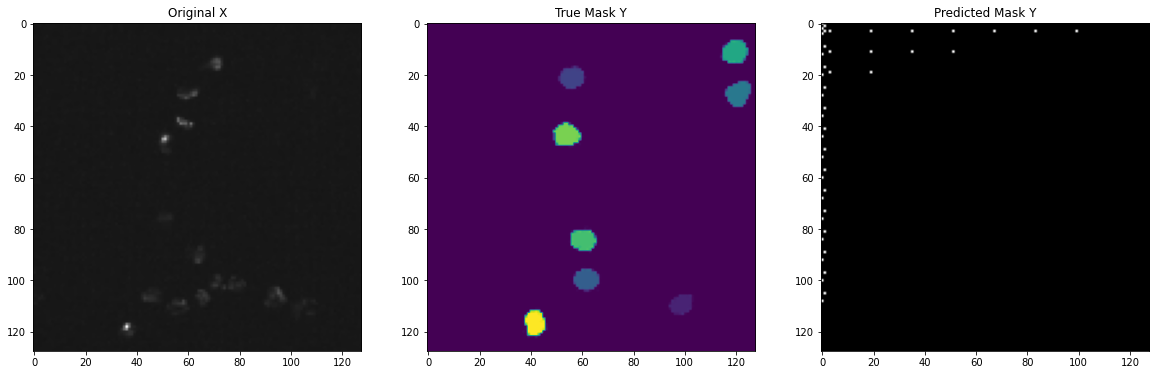

In [ ]:
# Try plot

index = randint(0, len(x_train)-1)

fig = plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plt.title("Original X")
plt.imshow( x_train[index] )

plt.subplot(1, 3, 2)
plt.title("True Mask Y")
plt.imshow( y_train[index] )

plt.subplot(1, 3, 3)
plt.title("Predicted Mask Y")
plt.imshow( np.squeeze(preds_train_t[index]), cmap="gray" )

plt.show()


That's not a good mapping... let us try train again until our loss is small and see:

In [ ]:
LOSS_THRESHOLD = 0

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('loss') > LOSS_THRESHOLD):
			print("\nReached %2.2f%% loss, so stopping training!!" %(LOSS_THRESHOLD*100))
			self.model.stop_training = True

# Instantiate a callback object
CALLBACKS = myCallback()

In [ ]:
unet_model_rmsprop_5 = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_rmsprop_5.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=600

unet_model_rmsprop_5_history = unet_model_rmsprop_5.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    callbacks=CALLBACKS
                                    )

Epoch 1/600
6/7 [========================>.....] - ETA: 0s - loss: -113.0158 - accuracy: 0.0653

7/7 [==============================] - 3s 107ms/step - loss: -112.3321 - accuracy: 0.0584 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 2/600
7/7 [==============================] - 0s 42ms/step - loss: -132.4624 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 3/600
7/7 [==============================] - 0s 43ms/step - loss: -132.4669 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 4/600
7/7 [==============================] - 0s 43ms/step - loss: -132.4595 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 5/600
7/7 [==============================] - 0s 42ms/step - loss: -132.4566 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 6/600
7/7 [==============================] - 0s 43ms/step - loss: -132.4491 - accuracy: 0.0051 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 7/600
7/7 [==============================] - 0s 42ms/step - loss: -132.4337 - accuracy: 0.0051 - val_loss: -132.6740 - val_accura

In [ ]:
training_predictions = unet_model_rmsprop_4.predict(x_train, verbose=1)

4/4 [==============================] - 0s 30ms/step


In [ ]:
preds_train_t = (training_predictions > 0.5).astype(np.uint8)

what are the max values?

In [ ]:
print(np.max(y_train[0]))
print(np.max(preds_train_t[0]))

255
0


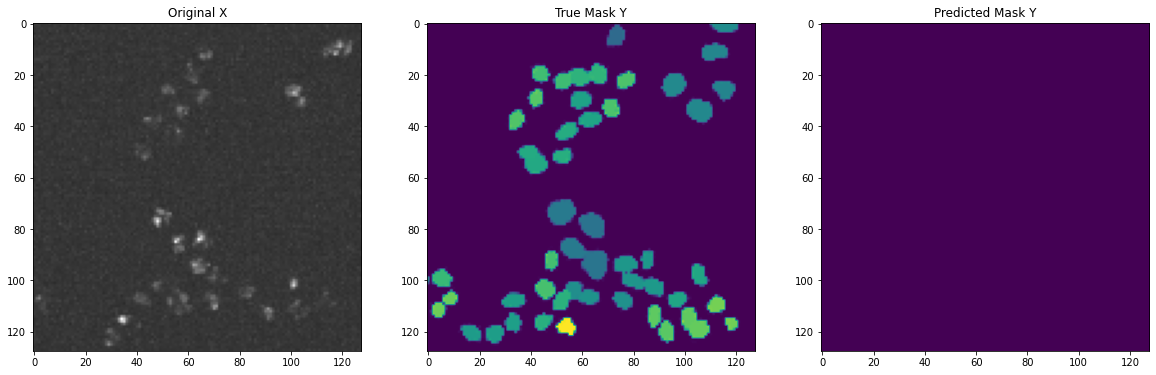

In [ ]:
# Try plot

index = randint(0, len(x_train)-1)

fig = plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plt.title("Original X")
plt.imshow( x_train[index] )

plt.subplot(1, 3, 2)
plt.title("True Mask Y")
plt.imshow( y_train[index] )

plt.subplot(1, 3, 3)
plt.title("Predicted Mask Y")
plt.imshow( np.squeeze(preds_train_t[index]))

plt.show()


Let's try one more training, without any callbacks:

In [ ]:
unet_model_rmsprop_6 = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_rmsprop_6.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=600

unet_model_rmsprop_6_history = unet_model_rmsprop_6.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    # callbacks=CALLBACKS
                                    )

Epoch 1/600
7/7 [==============================] - 3s 109ms/step - loss: -111.1337 - accuracy: 0.0436 - val_loss: -132.7637 - val_accuracy: 0.0092
Epoch 2/600
7/7 [==============================] - 0s 45ms/step - loss: -132.5700 - accuracy: 0.0121 - val_loss: -120.2441 - val_accuracy: 0.0176
Epoch 3/600
7/7 [==============================] - 0s 43ms/step - loss: -132.3970 - accuracy: 0.0107 - val_loss: -132.7940 - val_accuracy: 0.0127
Epoch 4/600
7/7 [==============================] - 0s 42ms/step - loss: -132.5836 - accuracy: 0.0137 - val_loss: -132.8064 - val_accuracy: 0.0146
Epoch 5/600
7/7 [==============================] - 0s 43ms/step - loss: -132.6076 - accuracy: 0.0158 - val_loss: -132.8154 - val_accuracy: 0.0183
Epoch 6/600
7/7 [==============================] - 0s 45ms/step - loss: -132.6157 - accuracy: 0.0189 - val_loss: -132.8279 - val_accuracy: 0.0203
Epoch 7/600
7/7 [==============================] - 0s 43ms/step - loss: -130.8927 - accuracy: 0.0226 - val_loss: -132.8027 

In [ ]:
training_predictions = unet_model_rmsprop_6.predict(x_train, verbose=1)

4/4 [==============================] - 0s 30ms/step


In [ ]:
preds_train_t = (training_predictions > 0.5).astype(np.uint8)

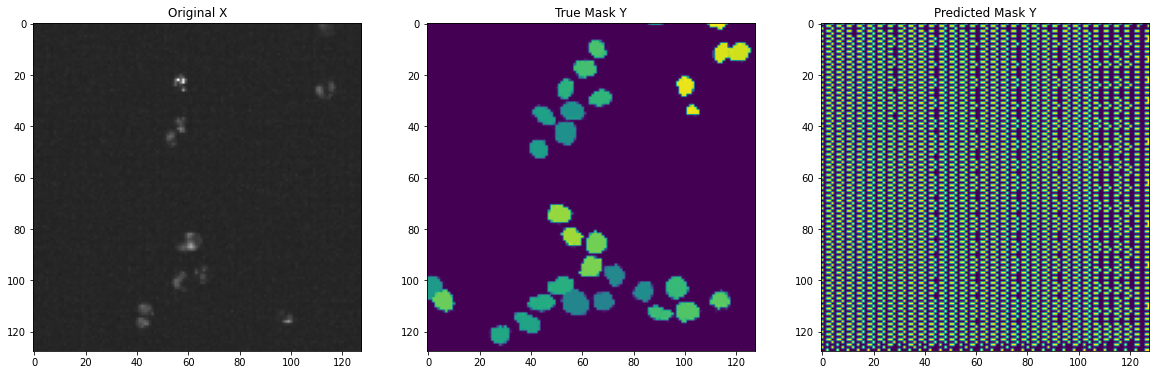

In [ ]:
# Try plot

index = randint(0, len(x_train)-1)

fig = plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plt.title("Original X")
plt.imshow( x_train[index] )

plt.subplot(1, 3, 2)
plt.title("True Mask Y")
plt.imshow( y_train[index] )

plt.subplot(1, 3, 3)
plt.title("Predicted Mask Y")
plt.imshow( np.squeeze(preds_train_t[index]))

plt.show()


That's better than before!

Let's try again with more epochs:

In [ ]:
unet_model_rmsprop_7 = get_unet(IMG_WIDTH, IMG_HEIGHT, IMG_INPUT, IMG_OUTPUT)

unet_model_rmsprop_7.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# change epochs size

VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
EPOCHS=1000

unet_model_rmsprop_7_history = unet_model_rmsprop_7.fit(
                                    x=x_train, 
                                    y=y_train, 
                                    validation_split=VALIDATION_SPLIT, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    # callbacks=CALLBACKS
                                    )

Epoch 1/1000
7/7 [==============================] - 3s 108ms/step - loss: -111.0301 - accuracy: 0.0065 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 2/1000
7/7 [==============================] - 0s 46ms/step - loss: -132.4668 - accuracy: 0.0050 - val_loss: -132.6740 - val_accuracy: 0.0048
Epoch 3/1000
7/7 [==============================] - 0s 43ms/step - loss: -132.4670 - accuracy: 0.0050 - val_loss: -132.6743 - val_accuracy: 0.0048
Epoch 4/1000
7/7 [==============================] - 0s 43ms/step - loss: -132.4927 - accuracy: 0.0072 - val_loss: -132.7323 - val_accuracy: 0.0084
Epoch 5/1000
7/7 [==============================] - 0s 43ms/step - loss: -132.5304 - accuracy: 0.0090 - val_loss: -132.7690 - val_accuracy: 0.0106
Epoch 6/1000
7/7 [==============================] - 0s 44ms/step - loss: -132.4236 - accuracy: 0.0094 - val_loss: -132.7326 - val_accuracy: 0.0086
Epoch 7/1000
7/7 [==============================] - 0s 46ms/step - loss: -132.5320 - accuracy: 0.0093 - val_loss: -13

In [ ]:
training_predictions = unet_model_rmsprop_7.predict(x_train, verbose=1)

preds_train_t = (training_predictions > 0.5).astype(np.uint8)


4/4 [==============================] - 1s 30ms/step


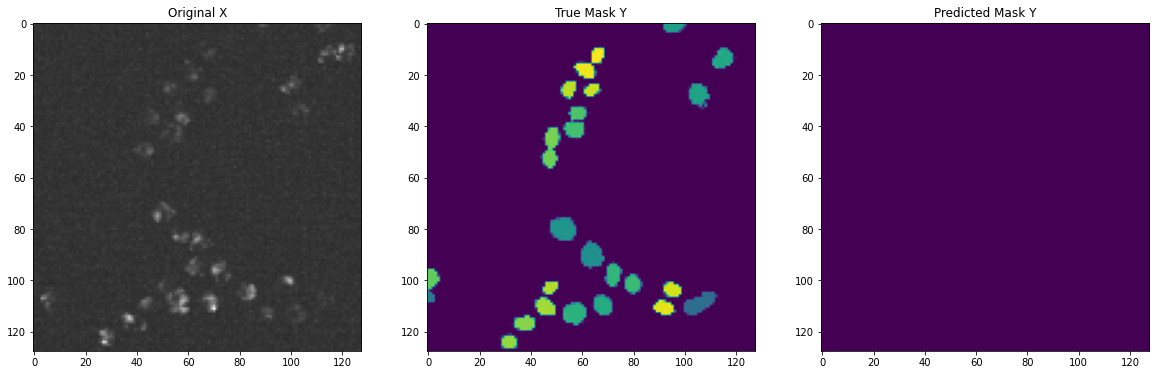

In [ ]:
# Try plot

index = randint(0, len(x_train)-1)

fig = plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plt.title("Original X")
plt.imshow( x_train[index] )

plt.subplot(1, 3, 2)
plt.title("True Mask Y")
plt.imshow( y_train[index] )

plt.subplot(1, 3, 3)
plt.title("Predicted Mask Y")
plt.imshow( np.squeeze(preds_train_t[index]))

plt.show()


No, we have hit a ceiling. I will revisit this later to give Google Colab a break

This was an interesting read:

https://stackoverflow.com/questions/43674411/training-and-loss-not-changing-in-keras-cnn-model

https://datascience.stackexchange.com/questions/19578/why-my-training-and-validation-loss-is-not-changing

https://github.com/keras-team/keras/issues/2711

From those resources, the notes are suggesting I do the following:

- Check Train Data Feeding Is Randomise. Make sure you are not feeding your train data to the model one class at a time

- Ramp Down Learning Rate: Keep reducing your learning rate by factors of 10 and retrying. Note you will have to fully reinitialize the layers you are trying to train each time you try a new learning rate. (For instance, I had this issue that was only solved once I got down to lr=1e-6, so keep going!)

- You can try to add a BatchNornmalization() layer after MaxPooling2D()

- Dying ReLU Problem may contribute if the loss begins at a large value

- Modifying Batch Size (64)

- Shuffling Data

- Changing Dropout Rate

I will creata a new notebook and investigate these things, using the Unet architecture that was successful here and modifying things alongside the RMSprop optimizer